# EV Charging Two-Stage Pipeline: Complete Evaluation

**Goal:** Implement and evaluate an end-to-end pipeline that:
1. **Stage 1 (Classifier):** Predicts if a session will be Long (≥24h) or Short (<24h)
2. **Stage 2 (Regressor):** For predicted-short sessions, estimates duration in hours

**Features:** Time patterns, weather (continuous + categorical flags), location, and user/garage aggregates.

**No Target Leakage:** Only engineered features are used; datetime stamps and duration are never fed as inputs.

In [13]:
# Import Required Libraries
import os, warnings, json
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (roc_auc_score, confusion_matrix, classification_report, precision_recall_fscore_support,
                             mean_squared_error, mean_absolute_error, r2_score)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load data and create CHRONOLOGICAL train/test split (no shuffle!)
csv_path = 'data/ev_sessions_clean.csv'
df = pd.read_csv(csv_path)

# Sort by start time to ensure temporal ordering
df['Start_plugin_dt'] = pd.to_datetime(df['Start_plugin_dt'])
df = df.sort_values('Start_plugin_dt').reset_index(drop=True)

# Chronological split: first 80% train, last 20% test
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f'Train: {len(train_df)} sessions | {train_df["Start_plugin_dt"].min()} to {train_df["Start_plugin_dt"].max()}')
print(f'Test:  {len(test_df)} sessions | {test_df["Start_plugin_dt"].min()} to {test_df["Start_plugin_dt"].max()}')
print(f'\n✓ Chronological split (train on past, test on future)')

Train: 5396 sessions | 2018-12-21 10:24:00 to 2019-12-28 16:00:00
Test:  1349 sessions | 2019-12-28 16:09:00 to 2020-01-31 20:42:00

✓ Chronological split (train on past, test on future)


---
## STAGE 1: Long Session Classification (≥24h)

Train a classifier to identify sessions likely to last 24+ hours using enhanced features including weather flags.

In [6]:
# Build user/garage aggregates from TRAIN ONLY to prevent leakage
def build_aggregates(train_df):
    user_agg = train_df.groupby('User_ID').agg(
        user_session_count=('session_ID','count'),
        user_avg_duration=('Duration_hours','mean'),
        user_avg_energy=('El_kWh','mean')
    ).reset_index()
    gar_agg = train_df.groupby('Garage_ID').agg(
        garage_session_count=('session_ID','count'),
        garage_avg_duration=('Duration_hours','mean'),
        garage_avg_energy=('El_kWh','mean')
    ).reset_index()
    return user_agg, gar_agg

user_agg, gar_agg = build_aggregates(train_df)

def merge_aggregates(df_in):
    df_m = df_in.merge(user_agg, on='User_ID', how='left').merge(gar_agg, on='Garage_ID', how='left')
    # Fill missing aggregates with train means / zeros for counts
    df_m['user_session_count'] = df_m['user_session_count'].fillna(0)
    df_m['garage_session_count'] = df_m['garage_session_count'].fillna(0)
    dur_mean = train_df['Duration_hours'].mean()
    eng_mean = train_df['El_kWh'].mean()
    df_m['user_avg_duration'] = df_m['user_avg_duration'].fillna(dur_mean)
    df_m['garage_avg_duration'] = df_m['garage_avg_duration'].fillna(dur_mean)
    df_m['user_avg_energy'] = df_m['user_avg_energy'].fillna(eng_mean)
    df_m['garage_avg_energy'] = df_m['garage_avg_energy'].fillna(eng_mean)
    return df_m

train_enh = merge_aggregates(train_df)
test_enh = merge_aggregates(test_df)

print('✓ User/garage aggregates built and merged')

✓ User/garage aggregates built and merged


In [7]:
# Define enhanced feature set with weather flags
base_num = ['hour_sin','hour_cos','temp','precip','wind_spd','clouds','solar_rad']
weather_flags = ['is_rainy','is_overcast','is_sunny']
agg_num = ['user_session_count','user_avg_duration','user_avg_energy',
           'garage_session_count','garage_avg_duration','garage_avg_energy']
base_cat = ['weekday','Garage_ID','month_plugin']

num_features = base_num + weather_flags + agg_num
cat_features = base_cat

print(f'Features defined: {len(num_features)} numerical, {len(cat_features)} categorical')
print('Numerical:', num_features)
print('Categorical:', cat_features)

Features defined: 16 numerical, 3 categorical
Numerical: ['hour_sin', 'hour_cos', 'temp', 'precip', 'wind_spd', 'clouds', 'solar_rad', 'is_rainy', 'is_overcast', 'is_sunny', 'user_session_count', 'user_avg_duration', 'user_avg_energy', 'garage_session_count', 'garage_avg_duration', 'garage_avg_energy']
Categorical: ['weekday', 'Garage_ID', 'month_plugin']


In [8]:
# Train RandomForest regressor on short-only sessions with log1p transform
train_short = train_enh[train_enh['Duration_hours'] < 24].copy()
X_train_reg = train_short[num_features + cat_features]
y_train_reg = np.log1p(train_short['Duration_hours'].values)

preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

rf_reg = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, min_samples_leaf=2)
rf_pipe = Pipeline([('prep', preprocessor_reg), ('rf', rf_reg)])
rf_pipe.fit(X_train_reg, y_train_reg)

print('✓ Stage 2 Regressor trained on short-only sessions')

✓ Stage 2 Regressor trained on short-only sessions


---
## PIPELINE EVALUATION: Route & Measure

Route test sessions through the pipeline and evaluate end-to-end performance.

---
## STAGE 2: Short Session Regression (<24h)

Train a regression model on short-only sessions to predict duration in hours.

In [9]:
# Prepare Stage 1 training data
from sklearn.ensemble import HistGradientBoostingClassifier

preprocessor_cls = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_train_cls = train_enh[num_features + cat_features]
y_train_cls = (1 - train_enh['is_short_session']).astype(int)  # 1=Long, 0=Short

X_test_cls = test_enh[num_features + cat_features]
y_test_cls = (1 - test_enh['is_short_session']).astype(int)

X_train_p = preprocessor_cls.fit_transform(X_train_cls)
X_test_p = preprocessor_cls.transform(X_test_cls)

# Convert to dense for HistGradientBoosting
X_train_dense = X_train_p.toarray() if hasattr(X_train_p, 'toarray') else X_train_p
X_test_dense = X_test_p.toarray() if hasattr(X_test_p, 'toarray') else X_test_p

print(f'Train: {X_train_dense.shape} | Test: {X_test_dense.shape}')
print(f'Class balance (Long): Train {y_train_cls.mean():.1%} | Test {y_test_cls.mean():.1%}')

Train: (5396, 57) | Test: (1349, 57)
Class balance (Long): Train 6.4% | Test 8.1%


In [14]:
# Train HistGradientBoosting classifier (handles imbalance with sample weights)
scale_pos = (1 - y_train_cls.mean()) / y_train_cls.mean()
sample_weights = np.where(y_train_cls == 1, scale_pos, 1.0)

clf = HistGradientBoostingClassifier(
    max_iter=300,
    max_depth=6,
    learning_rate=0.05,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42,
    verbose=0
)

clf.fit(X_train_dense, y_train_cls, sample_weight=sample_weights)

# Predict probabilities
proba_long = clf.predict_proba(X_test_dense)[:, 1]
auc_long = roc_auc_score(y_test_cls, proba_long)

print(f'✓ Stage 1 Classifier trained')
print(f'  AUC (Long vs Short): {auc_long:.3f}')

✓ Stage 1 Classifier trained
  AUC (Long vs Short): 0.751


In [15]:
# Tune threshold to maximize F1 score for Long class
thresholds = np.linspace(0.1, 0.9, 40)
best_thr = {'thr':0.5, 'f1':-1, 'prec':0, 'rec':0}

for t in thresholds:
    y_pred = (proba_long >= t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test_cls, y_pred, average='binary', zero_division=0)
    if f1 > best_thr['f1']:
        best_thr = {'thr':float(t), 'f1':float(f1), 'prec':float(prec), 'rec':float(rec)}

threshold = best_thr['thr']
print(f"✓ Optimal threshold: {threshold:.3f}")
print(f"  F1 (Long): {best_thr['f1']:.3f} | Precision: {best_thr['prec']:.3f} | Recall: {best_thr['rec']:.3f}")

# Confusion matrix
y_pred_cls = (proba_long >= threshold).astype(int)
cm = confusion_matrix(y_test_cls, y_pred_cls)
print(f"\nConfusion Matrix (Long=1, Short=0):")
print(cm)

✓ Optimal threshold: 0.695
  F1 (Long): 0.339 | Precision: 0.308 | Recall: 0.376

Confusion Matrix (Long=1, Short=0):
[[1148   92]
 [  68   41]]


In [16]:
# Route test sessions based on classifier predictions
pred_long_mask = (proba_long >= threshold)
pred_short_mask = ~pred_long_mask

actual_short_mask = (test_enh['Duration_hours'] < 24).values
actual_long_mask = ~actual_short_mask

# Predict on routed-short subset
X_test_short_routed = test_enh.loc[pred_short_mask, num_features + cat_features]
y_test_short_routed = test_enh.loc[pred_short_mask, 'Duration_hours'].values

if len(X_test_short_routed) > 0:
    y_pred_log = rf_pipe.predict(X_test_short_routed)
    y_pred_short = np.expm1(y_pred_log)
    
    rmse_routed = np.sqrt(mean_squared_error(y_test_short_routed, y_pred_short))
    mae_routed = mean_absolute_error(y_test_short_routed, y_pred_short)
    r2_routed = r2_score(y_test_short_routed, y_pred_short)
else:
    rmse_routed = mae_routed = r2_routed = np.nan
    y_pred_short = np.array([])

# Also evaluate on actual-short to see regressor quality
X_test_actual_short = test_enh.loc[actual_short_mask, num_features + cat_features]
y_test_actual_short = test_enh.loc[actual_short_mask, 'Duration_hours'].values

y_pred_log_actual = rf_pipe.predict(X_test_actual_short)
y_pred_actual_short = np.expm1(y_pred_log_actual)

rmse_actual = np.sqrt(mean_squared_error(y_test_actual_short, y_pred_actual_short))
mae_actual = mean_absolute_error(y_test_actual_short, y_pred_actual_short)
r2_actual = r2_score(y_test_actual_short, y_pred_actual_short)

coverage_short = pred_short_mask.mean()

print('=' * 60)
print('PIPELINE PERFORMANCE')
print('=' * 60)
print(f'Coverage (routed to Stage 2): {coverage_short:.1%}')
print(f'\nPredicted-short metrics (includes misrouted longs):')
print(f'  RMSE: {rmse_routed:.2f} | MAE: {mae_routed:.2f} | R²: {r2_routed:.3f}')
print(f'\nActual-short metrics (regressor quality on true shorts):')
print(f'  RMSE: {rmse_actual:.2f} | MAE: {mae_actual:.2f} | R²: {r2_actual:.3f}')

PIPELINE PERFORMANCE
Coverage (routed to Stage 2): 90.1%

Predicted-short metrics (includes misrouted longs):
  RMSE: 11.59 | MAE: 6.52 | R²: -0.081

Actual-short metrics (regressor quality on true shorts):
  RMSE: 6.47 | MAE: 4.82 | R²: 0.019



✓ Saved metrics to fig/pipeline/pipeline_metrics.csv


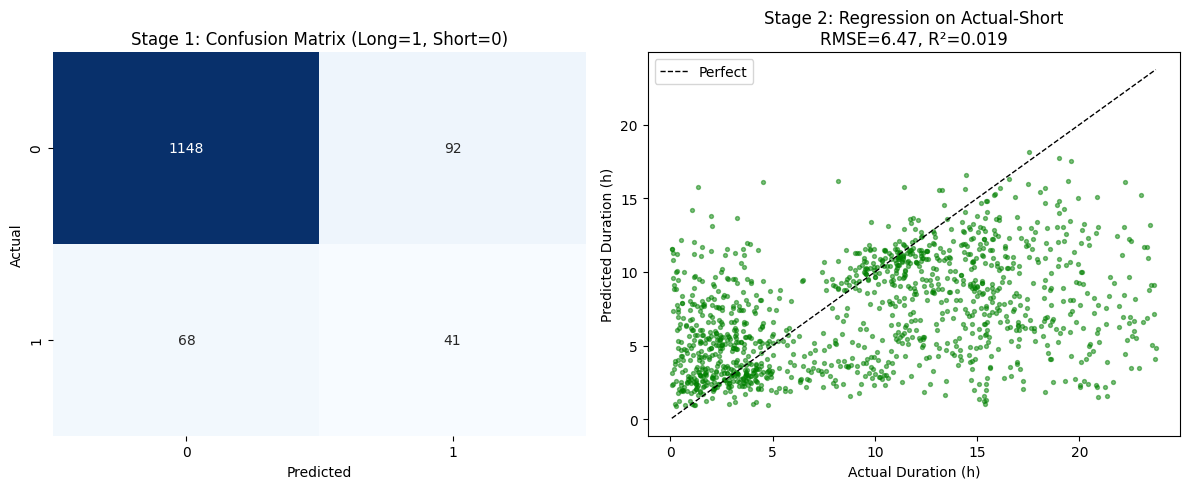

✓ Saved plots to fig/pipeline/pipeline_results.png


In [17]:
# Save metrics and visualizations
os.makedirs('fig/pipeline', exist_ok=True)

metrics = {
    'auc_long': float(auc_long),
    'threshold': float(threshold),
    'precision_long': float(best_thr['prec']),
    'recall_long': float(best_thr['rec']),
    'f1_long': float(best_thr['f1']),
    'coverage_short': float(coverage_short),
    'rmse_routed_short': float(rmse_routed),
    'mae_routed_short': float(mae_routed),
    'r2_routed_short': float(r2_routed),
    'rmse_actual_short': float(rmse_actual),
    'mae_actual_short': float(mae_actual),
    'r2_actual_short': float(r2_actual),
}

pd.DataFrame([metrics]).to_csv('fig/pipeline/pipeline_metrics.csv', index=False)
print('\n✓ Saved metrics to fig/pipeline/pipeline_metrics.csv')

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Stage 1: Confusion Matrix (Long=1, Short=0)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot regression scatter
if len(y_pred_actual_short) > 0:
    axes[1].scatter(y_test_actual_short, y_pred_actual_short, s=8, alpha=0.5, color='green')
    mn, mx = y_test_actual_short.min(), y_test_actual_short.max()
    axes[1].plot([mn, mx], [mn, mx], 'k--', lw=1, label='Perfect')
    axes[1].set_xlabel('Actual Duration (h)')
    axes[1].set_ylabel('Predicted Duration (h)')
    axes[1].set_title(f'Stage 2: Regression on Actual-Short\nRMSE={rmse_actual:.2f}, R²={r2_actual:.3f}')
    axes[1].legend()

plt.tight_layout()
plt.savefig('fig/pipeline/pipeline_results.png', dpi=120)
plt.show()

print('✓ Saved plots to fig/pipeline/pipeline_results.png')